In [67]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from uncertainties import ufloat
import seaborn as sns
from joblib import delayed, Parallel
from glob import glob

import sys
sys.path.append("../../")

import tetrahedron
import proj_quality
from metric.metric import Euclid

import pivot_selection
import point_generator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
df = pd.concat((pd.read_csv(f) for f in glob("results/*.csv")))
df = df.drop(columns=["Unnamed: 0"])
df = df.drop_duplicates()
len(set(df.run))

78

In [69]:
failed = df.query("note == 'failed'")
assert set(failed.dim) == {2}
assert set(failed.algorithm) == {"hilbert_optimal"}

# XXX: quick fix: let's exclude dim=2
results = df.query("dim != 2").copy()
assert len(results.query("note == 'failed'")) == 0
results = results.drop(columns=["note"])

In [70]:

# drop_ratio = 0.25
# measure = "hilbert_quality"
# def _drop_worst(group:pd.DataFrame):
    # thresh = group[measure].quantile(drop_ratio)
    # return group[group[measure] > thresh]
    
# normalized_res = results.groupby(["dim","dataset", "algorithm"]).apply(_drop_worst, include_groups=False)
# normalized_res = normalized_res.reset_index()#.drop(columns="level_2")
# assert np.allclose(1-len(normalized_res)/len(results), drop_ratio,atol=0.05)


In [71]:
# measure = "hilbert_quality"
# def _discard_if_worse_than_random(group):
    # group = group.reset_index(drop=True)
    # mean = group.groupby("algorithm")[measure].mean()
    # std =  group.groupby("algorithm")[measure].std()
    # thresh = mean["random"] - std["random"]
    # discard = mean.index[mean < thresh]
    # return group[~group.algorithm.isin(discard)]
# 
# # drop stuff worse than random
# normalized_res = normalized_res.groupby(["dim","dataset"]).apply(_discard_if_worse_than_random, include_groups=False)#.reset_index(drop=False)
# normalized_res = normalized_res.reset_index().drop(columns="level_2")

<Axes: xlabel='dim', ylabel='hilbert_quality'>

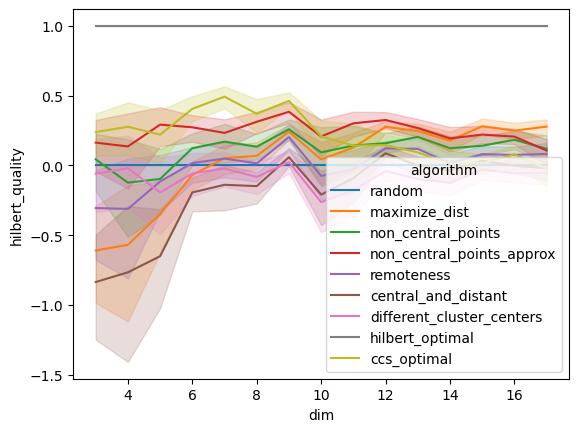

In [75]:
def _normalize(df):
    # higher is better
    lower_bound = df.query("algorithm == 'random'").hilbert_quality.mean()
    df.hilbert_quality -= lower_bound
    upper_bound = df.query("algorithm == 'hilbert_optimal'").hilbert_quality.mean()
    df.hilbert_quality /= upper_bound

    # add candidate set quality
    # best_result = df.query("algorithm == 'ccs_optimal'").mean_candidate_set_size.mean()
    # # 0 is optimal
    # df["csq"] = best_result - df.mean_candidate_set_size
    # # # 0 is random
    # df["csq"] -= df.query("algorithm == 'random'").csq.mean()
    # # 1 is optimal
    # df["csq"] /= df.query("algorithm == 'ccs_optimal'").csq.mean()
    # df = df.rename(columns=dict(csq="mean_candidate_set_quality"))
    
    # lower is better
    lower_bound = df.query("algorithm == 'ccs_optimal'").mean_candidate_set_size.mean()
    df.mean_candidate_set_size -= lower_bound
    upper_bound = df.query("algorithm == 'random'").mean_candidate_set_size.mean()
    df.mean_candidate_set_size /= upper_bound

    return df

# TODO: Decide on whether to normalize per run (grp + ["run"])
# TODO: Choose whether to do candidate set size or quality (maybe just invert the y-axis visially only?)
# TODO: Choose color scheme for beyond 1 and 0 filly

grp = ["dataset", "dim"]  #"run"]
normalized_res = results.groupby(grp).apply(
    _normalize, include_groups=False
)
normalized_res = normalized_res.reset_index(level=grp)
normalized_res

#assert all(normalized_res.query("algorithm != 'hilbert_optimal'").hilbert_quality <= 2)
ex = normalized_res.query("dataset == 'univariate, stretched'")
sns.lineplot(ex, x="dim", y="hilbert_quality", hue="algorithm")

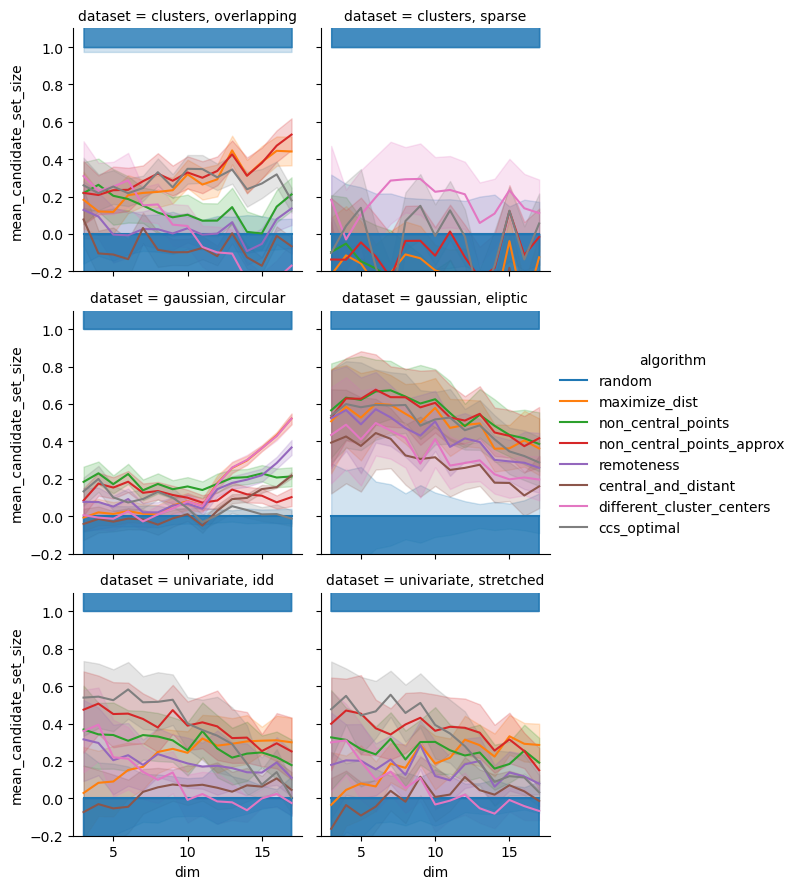

In [78]:
g = sns.FacetGrid(
    data=normalized_res.query("algorithm != 'hilbert_optimal'"),
    col="dataset",
    hue="algorithm",
    col_wrap=2,
)

def plot_single(x,y, **kwargs):
    data = kwargs.pop('data')
    #sns.lineplot(data=data,x=x,y=y, **kwargs)
    ax = plt.gca()
    ax.fill_between(data[x], 1, ax.get_ylim()[1], alpha=0.2, color="C0")
    ax.fill_between(data[x], 0, ax.get_ylim()[0], alpha=0.2, color="C0")
    
g.map(sns.lineplot, "dim", "hilbert_quality")
g.map_dataframe(plot_single, "dim", "mean_candidate_set_size")

g.set(ylim=(-0.2, 1.1))
g.add_legend()
g.savefig("fig/css.svg")